In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import RegularGridInterpolator

from paiskintonetools import setup_matplotlib

import matplotlib as mpl

setup_matplotlib(dpi=300)

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [ ]:
def mua_melanin(x, mvf):
    return 519 * (x / 500) ** (-3.5) * mvf / 10  # /mm

In [3]:
df = pd.read_csv("cali_curve.csv", index_col=0)
df.set_index(["MVF", "WL"], inplace=True, drop=False)

df["Compare Fluence"] = np.exp(-mua_melanin(df["WL"], df["MVF"]) * 0.06)

for n, g in df.groupby(level=0):
    # print(df.loc[(0.02, ), "Fluence"])
    df.loc[(n,), "Normalised"] = (
        df.loc[(n,), "Fluence"].values / df.loc[(0.02,), "Fluence"].values
    )

In [4]:
cmap = mpl.cm.viridis_r
norm = mpl.colors.Normalize(vmin=np.min(df["MVF"]) * 100, vmax=np.max(df["MVF"]) * 100)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

In [5]:
for n, _ in df.groupby(level=0):
    # print(df.loc[(0.02, ), "Fluence"])
    df.loc[(n,), "Normalised Baseline"] = (
        df.loc[(n,), "Compare Fluence"].values
        / df.loc[(0.02,), "Compare Fluence"].values
    )

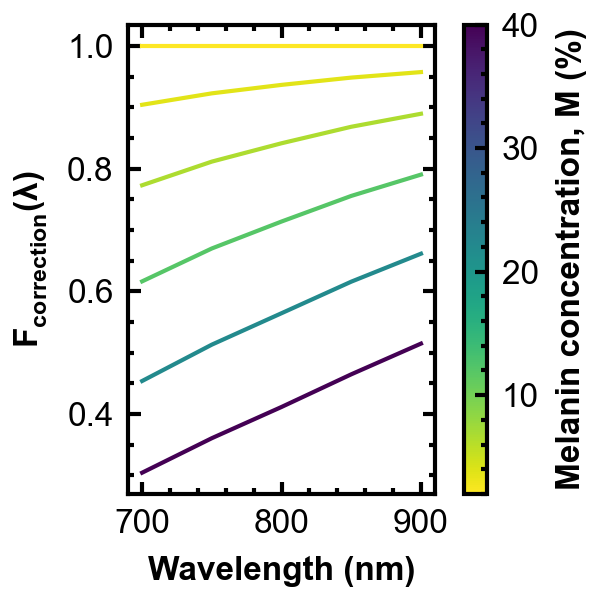

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2.0))
i = 0
for n, g in df.groupby(level=0):
    plot_line = ax.plot(
        np.linspace(700, 900, 5),
        g["Normalised"],
        label=f"Fitzpatrick {i + 1}",
        color=cmap(norm(n * 100)),
    )
    i += 1
plt.colorbar(sm, ax=ax, label="Melanin concentration, M (%)")
fig.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, 0), ncol=3)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(r"$\mathdefault{F_{correction}(\lambda)}$")
fig.savefig("fluence_factor.pdf", dpi=300)
# fig.savefig("fluence_factor.pdf", dpi=300)
plt.show()

# Set up an interpolation in MVF and WL

In [7]:
wavelengths = df.index.get_level_values(1)[:5].values
mvf = df.index.get_level_values(0)[::5].values

In [8]:
norm_grid = -np.log(df["Normalised"].values.reshape((-1, 5)))

correction_factor_spline = RegularGridInterpolator(
    (wavelengths, mvf), norm_grid.T, method="cubic"
)
correction_factor_spline((880, 0.02))

array(0.)

In [9]:
mvf_eval = np.linspace(0.02, 0.4 - 1e-9, 11)
wavelength_eval = np.linspace(700, 900, 11)

WL, MV = np.meshgrid(wavelength_eval, mvf_eval, indexing="ij")

interped = correction_factor_spline((WL, MV))

interped -= interped[:, 0:1]

## Plot the correction factors

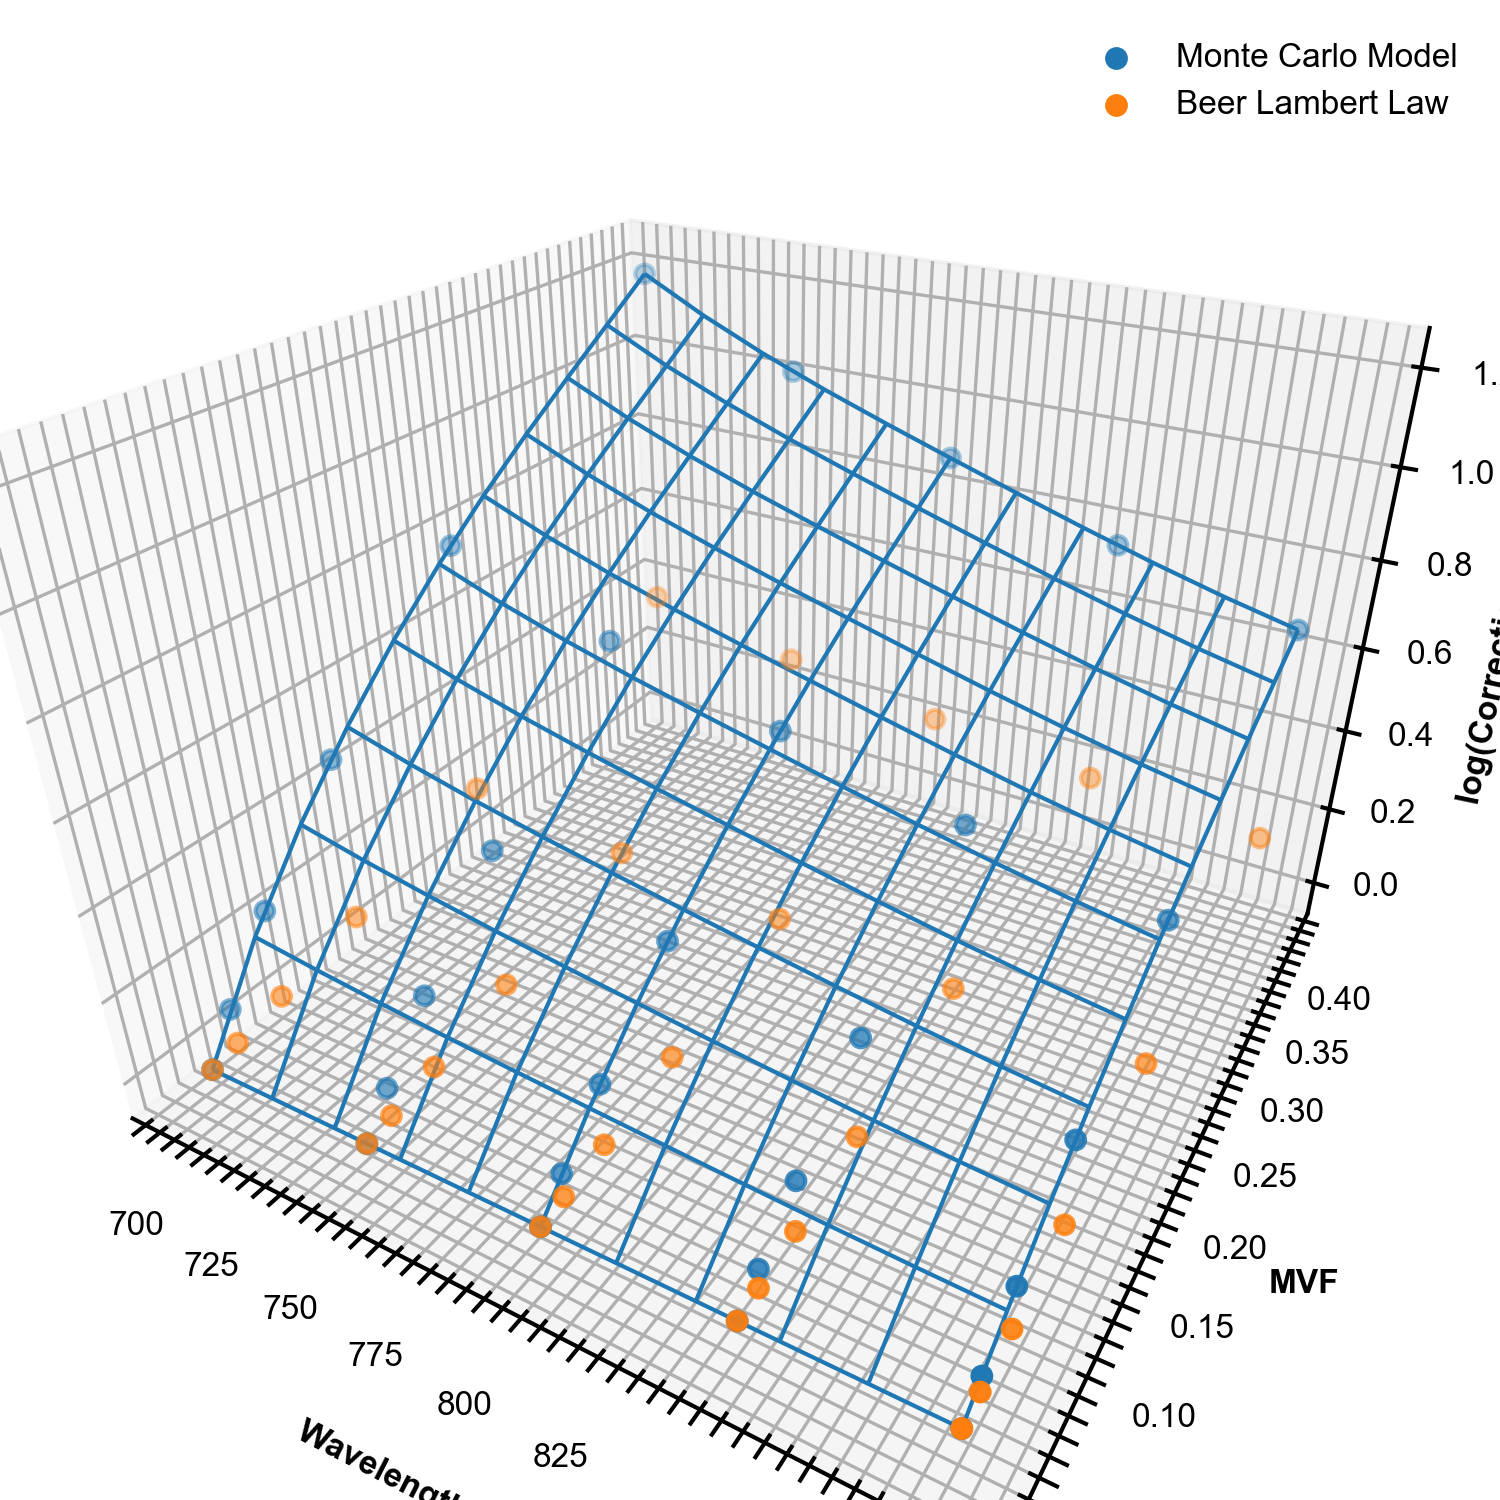

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")
ax.scatter(df["WL"], df["MVF"], -np.log(df["Normalised"]), label="Monte Carlo Model")
ax.plot_wireframe(WL, MV, interped)

ax.scatter(
    df["WL"], df["MVF"], -np.log(df["Normalised Baseline"]), label="Beer Lambert Law"
)
ax.set_ylabel("MVF")
ax.set_xlabel("Wavelength (nm)")
ax.set_zlabel("log(Correction Factor)")
ax.legend(frameon=False)
ax.set_proj_type("persp", focal_length=0.2)
plt.show()